## Final Project Submission

Please fill out:
* Student name: Devin Belden
* Student pace: full time
* Scheduled project review date/time: Tue, Oct 29, 2019, 3:30 PM - 4:15 PM
* Instructor name: James Irving, Ph.D
* Blog post URL: Unknown

# Business Case

The purpose of this technical notebook is to explore the housing market in King County, Washington, so as to provide a healthy amount of information to prospective investors before or after they've invested in a property in the area. In short, the goal is to answer the question: "What features of a property can be manipulated such that the selling price is increased, and the investor's profit is maximized?" 

## Obtaining/Exploring Data
* As always, we must import packages before loading in the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
%matplotlib inline
inline_rc = dict(mpl.rcParams)

plt.style.use('seaborn')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test
from scipy.stats import zscore

from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

C:\Users\Devin\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  import sys


In [2]:
df = pd.read_csv('kc_house_data.csv')
display(df.head())
display(df.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


None

## Preliminary Exploration

Let's do a quick check for multicollinearity between the variables we've got right now. For the scope of this project, we'll say that anything correlated higher than 0.75 should be dealt with, usually by removing a column from our actionable data.

Not only will this give us an idea of which variables _not_ to use, but it will give us an idea of what variables are correlated with our target variable (price) so we'll also have a list of candidates for our final, actionable dataset.

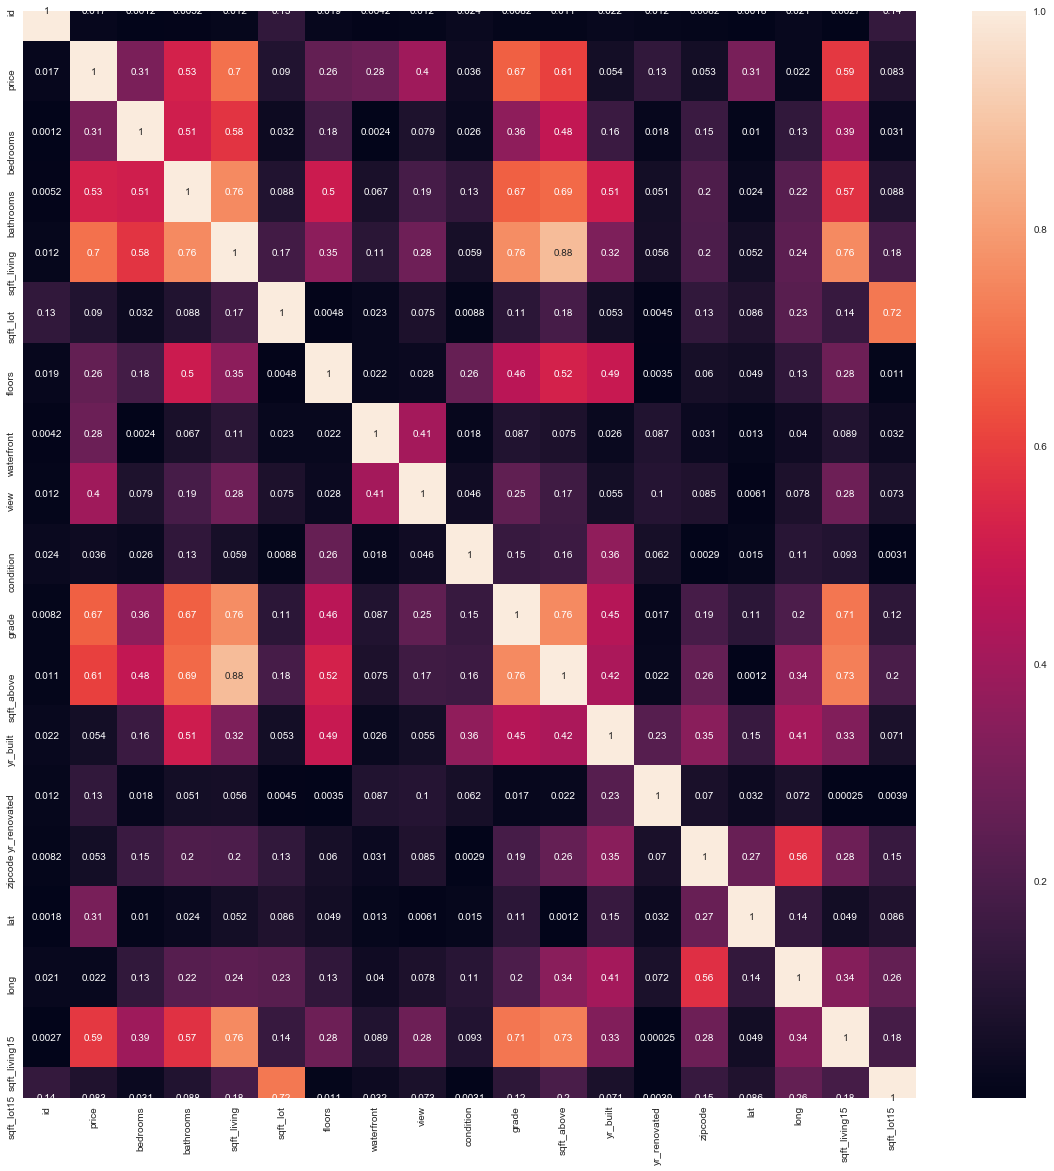

In [3]:
plt.figure(figsize=(20,20))
sns.heatmap(abs(df.corr()), annot=True);

So far, we can see that `sqft_living` is unacceptably highly correlated with a lot of other columns, including `bathrooms`, `sqft_above`, `sqft_living15`, and, for some reason, `grade`. For unknown reasons, `sqft_basement` is not included in our heatmap, but it's not a huge stretch of the imagination to think it might be highly collinear with `sqft_living` as well. For these reasons, it would behoove us to omit everything except `sqft_living`, as that gives the most information about the home's living space, and `grade`, because the idea that living space is correlated with the King County grading system seems out of left field. We'll keep `grade` for now, and do further exploratory analysis on this supposed collinearity in further steps.

For now, we'll also take a look at the distributions of the different columns to determine which transformations we'll need for continuous variables, as well as take a further look at categorical variables.

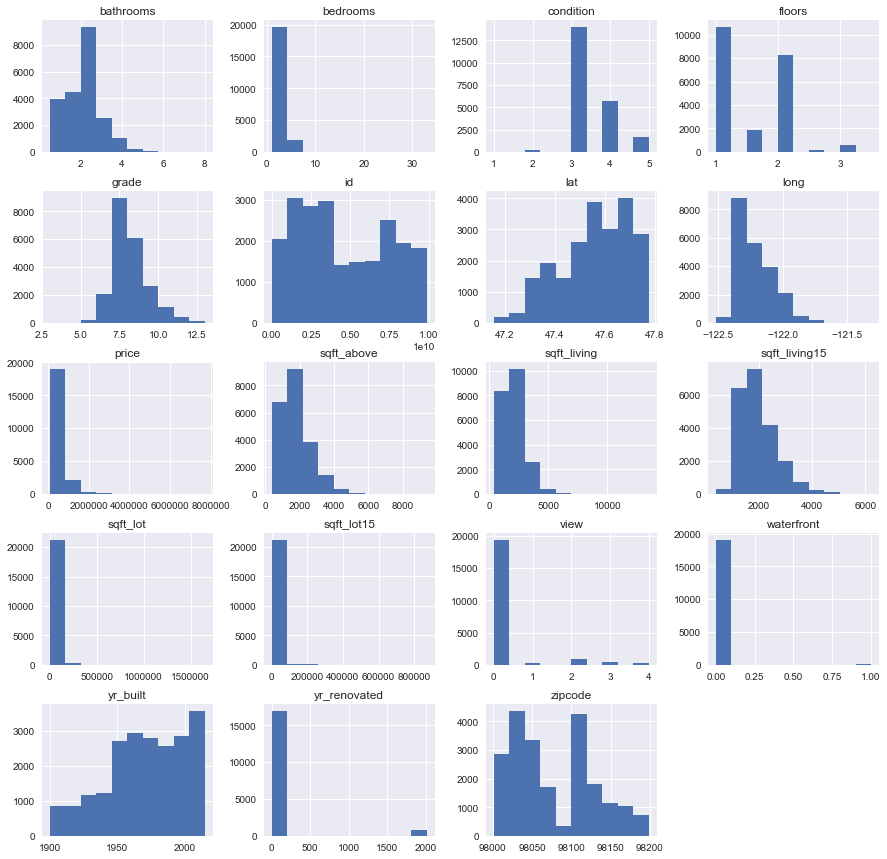

In [4]:
df.hist(figsize=(15,15));

A few takeaways from this: 
* There is at least one outlier in the `bedrooms` column
* There are some outliers in the `price` column
* `sqft_living` has a positive skew

We'll use Z-score to eliminate outliers for `bedrooms` and `price`, and use a log transform on `sqft_living` in an effort to improve the skew.

To visually investigate and confirm the existence of outliers, we can use boxplots:

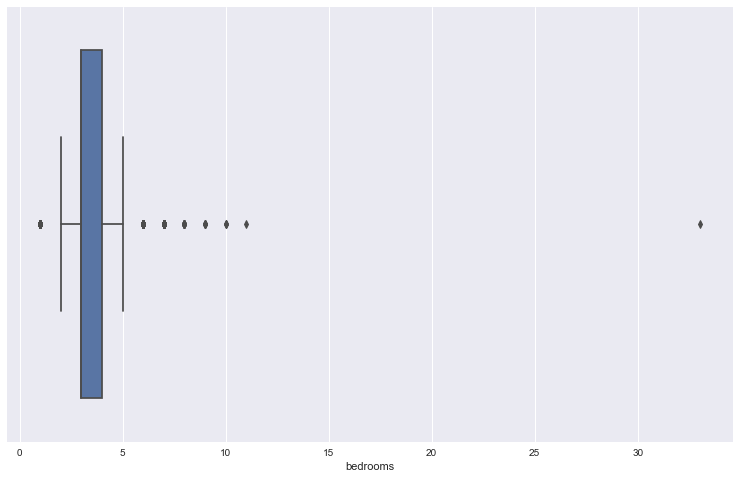

In [5]:
plt.figure(figsize=(13,8))
sns.boxplot(x='bedrooms', data=df)

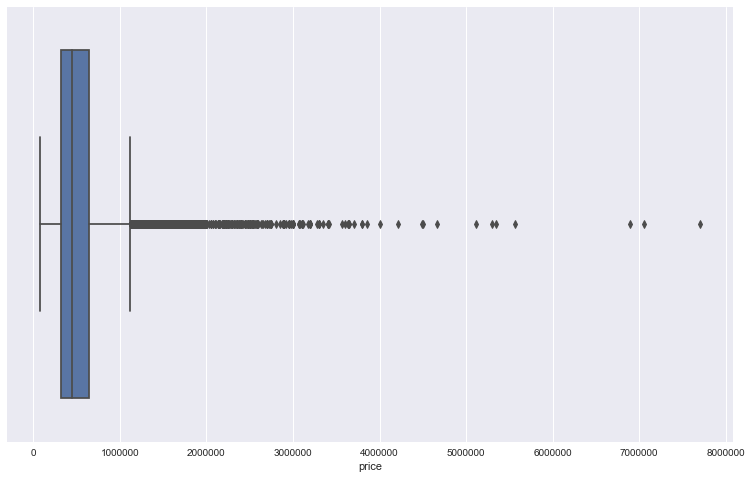

In [6]:
plt.figure(figsize=(13,8))
sns.boxplot(x='price', data=df)

And violin plots to visualize skew:

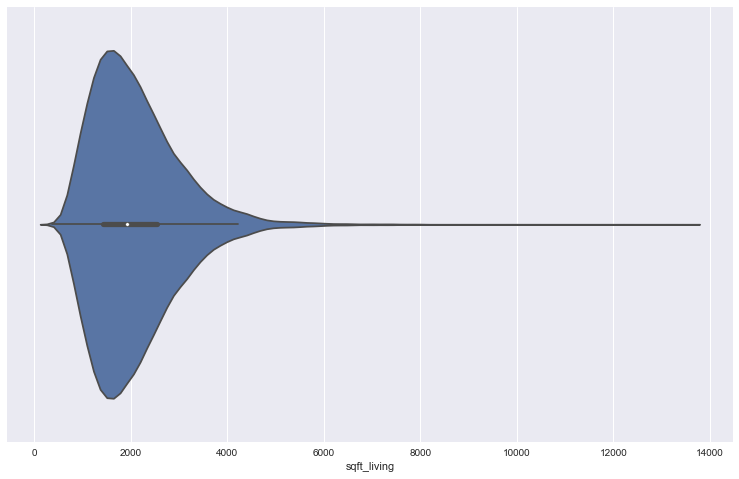

In [7]:
plt.figure(figsize=(13,8))
sns.violinplot(x='sqft_living', data=df)

These graphs both prove the existence of outliers in `price` and `bedrooms`, and demonstrate a relatively high level of skew in the `sqft_living` column.

## Data Cleaning
* There are nan's and '?' placeholders in certain columns
* We'll transform yr_renovated into a categorical column while we're at it

In [8]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [9]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2490.0        1
2050.0        1
2580.0        1
508.0         1
2196.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [10]:
df_temp = df.copy()
df_temp['yr_renovated'].fillna(0, inplace=True)
df_temp['is_renovated'] = df_temp['yr_renovated'].map(lambda x: x!=0)
df_temp['waterfront'].fillna(0, inplace=True)
df_temp['waterfront'] = df_temp['waterfront'].astype(int)
df_temp['view'].fillna(0., inplace=True)
df_temp['view'] = df_temp['view'].astype(int)
df_temp.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
is_renovated     0
dtype: int64

Additionally, we'll delete some of the columns deemed to be collinear in our temporary dataframe.

In [11]:
df_temp.drop(['bathrooms', 'sqft_basement', 'sqft_living15', 'sqft_above'], axis=1, inplace=True)

Now that we've taken care of the nan's and placeholders, let's eliminate some outliers.

### Outlier Identification and Elimination, with Variable Transformation

As we saw from our boxplots, there are some outliers in the data that will lead to inaccurate conclusions if allowed to persist. Using Z-score calculation, we can catch and remove these outliers.

Our goal is to replace the values in the dataframe with the respective Z-score, and to create a new column for the Z-score of our target variable. This will allow us to build a linear model using the transformed columns, while keeping the raw, untransformed data in the `price` column.

Before that, though, we'll need to take care of the skew of some of the variables. These variables include `bedrooms`, `sqft_living`, `sqft_lot`, `sqft_lot15`. `long` has skew to it, but since all of the values are below zero, log transforming will not work.

In [12]:
log_variables = ['bedrooms','sqft_living','sqft_lot','sqft_lot15']

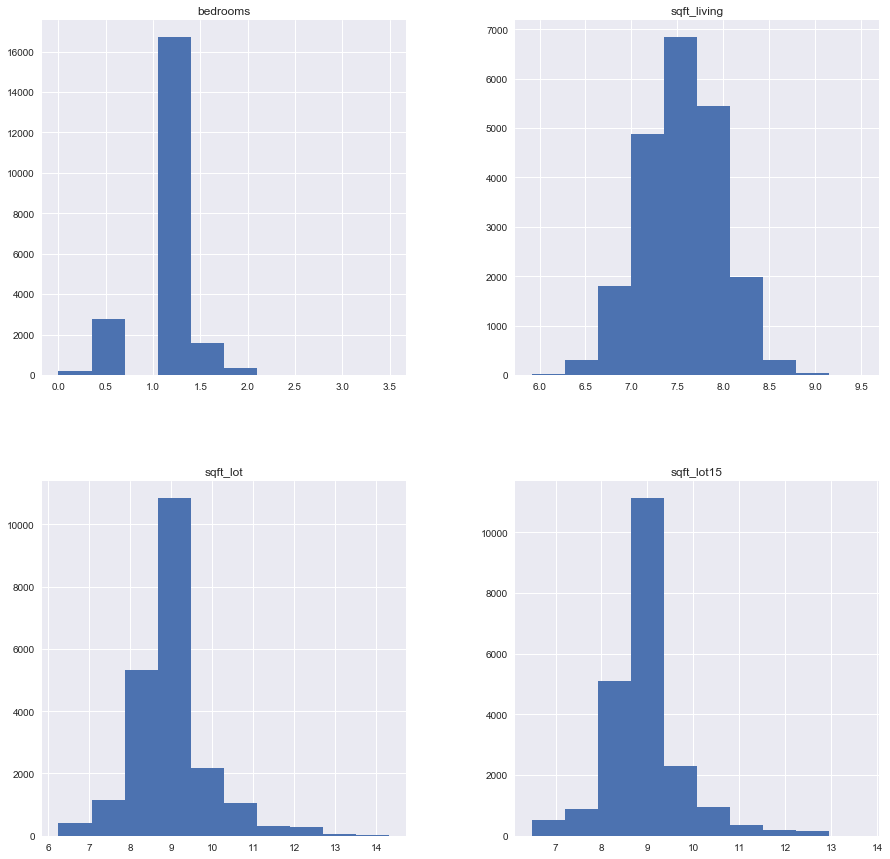

In [13]:
df_temp_log = pd.DataFrame([])
for variable in log_variables:
    df_temp_log[variable] = np.log(df_temp[variable])
df_temp_log.hist(figsize=(15,15));

The skew across these variables has been noticeably decreased. With some outlier elimination, we can use these transformed variables in our preliminary models. We'll go ahead and drop the untransformed variables in the working dataframe.

In [14]:
df_temp.drop(['bedrooms','sqft_living','sqft_lot','sqft_lot15'], axis=1, inplace=True)

In [15]:
df_temp = pd.concat([df_temp, df_temp_log], axis=1)

In [16]:
df_temp.describe().round(3)
print(df_temp.columns)

Index(['id', 'date', 'price', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'is_renovated', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_lot15'],
      dtype='object')


Now we can go ahead and scale the data using Standardization. This will allow us to use Z-score to eliminate the outliers.

In [17]:
scaler = StandardScaler()

In [18]:
df_scaled = df_temp.copy()

In [19]:
cols = ['floors','sqft_lot','bedrooms','sqft_living','sqft_lot15']
df_scaled[cols] = scaler.fit_transform(df_scaled[cols].values)
df_scaled['scaled_price'] = scaler.fit_transform(df_scaled['price'].values.reshape(-1,1))
df_scaled.describe().round(3)

,id,price,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,sqft_lot15,scaled_price
count,2.159700e+04,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,4.580474e+09,540296.574,-0.000,0.007,0.233,3.410,7.658,1971.000,68.758,98077.952,47.560,-122.214,-0.000,-0.000,-0.000,-0.000,-0.000
std,2.876736e+09,367368.140,1.000,0.082,0.765,0.651,1.173,29.375,364.037,53.513,0.139,0.141,1.000,1.000,1.000,1.000,1.000
min,1.000102e+06,78000.000,-0.916,0.000,0.000,1.000,3.000,1900.000,0.000,98001.000,47.156,-122.519,-4.160,-3.860,-3.033,-3.055,-1.258
25%,2.123049e+09,322000.000,-0.916,0.000,0.000,3.000,7.000,1951.000,0.000,98033.000,47.471,-122.328,-0.280,-0.673,-0.515,-0.521,-0.594
50%,3.904930e+09,450000.000,0.011,0.000,0.000,3.000,7.000,1975.000,0.000,98065.000,47.572,-122.231,-0.280,0.010,-0.057,-0.027,-0.246
75%,7.308900e+09,645000.000,0.937,0.000,0.000,4.000,8.000,1997.000,0.000,98118.000,47.678,-122.125,0.736,0.691,0.318,0.317,0.285
max,9.900000e+09,7700000.000,3.717,1.000,4.000,5.000,13.000,2015.000,2015.000,98199.000,47.778,-121.315,8.189,4.627,5.906,5.805,19.490


In [20]:
df_scaled['price_outliers'] = df_scaled['scaled_price'].apply(lambda x: abs(x) > 3)
df_scaled['floors_outliers'] = df_scaled['floors'].apply(lambda x: abs(x) > 3)
df_scaled['bed_outliers'] = df_scaled['bedrooms'].apply(lambda x: abs(x) > 3)
df_scaled['sqft_living_outliers'] = df_scaled['sqft_living'].apply(lambda x: abs(x) > 3)
df_scaled['sqft_lot_outliers'] = df_scaled['sqft_lot'].apply(lambda x: abs(x) > 3)
df_scaled['sqft_lot15_outliers'] = df_scaled['sqft_lot15'].apply(lambda x: abs(x) > 3)

#Now we group by the outlier columns and only get the rows that have False in all outlier categories:
df_scaled.groupby(['price_outliers', 'floors_outliers', 'bed_outliers', 'sqft_living_outliers', 
                   'sqft_lot_outliers', 'sqft_lot15_outliers']).get_group(
                    (False, False, False, False, False, False)).head()

,id,date,price,floors,waterfront,view,condition,grade,yr_built,yr_renovated,...,sqft_living,sqft_lot,sqft_lot15,scaled_price,price_outliers,floors_outliers,bed_outliers,sqft_living_outliers,sqft_lot_outliers,sqft_lot15_outliers
0,7129300520,10/13/2014,221900.0,-0.915552,0,0,3,7,1955,0.0,...,-1.125582,-0.388439,-0.395459,-0.866716,False,False,False,False,False,False
1,6414100192,12/9/2014,538000.0,0.937431,0,0,3,7,1951,1991.0,...,0.709463,-0.113243,-0.024288,-0.006252,False,False,False,False,False,False
2,5631500400,2/25/2015,180000.0,-0.915552,0,0,3,6,1933,0.0,...,-2.131943,0.244481,0.042037,-0.980773,False,False,False,False,False,False
3,2487200875,12/9/2014,604000.0,-0.915552,0,0,5,7,1965,0.0,...,0.070676,-0.523926,-0.545863,0.173409,False,False,False,False,False,False
4,1954400510,2/18/2015,510000.0,-0.915552,0,0,3,8,1987,0.0,...,-0.292732,0.008140,-0.046395,-0.082471,False,False,False,False,False,False


In [21]:
#Here we give our groupby statement some permanence
df_scaled = df_scaled[(df_scaled['price_outliers'] == False)
                    & (df_scaled['floors_outliers'] == False)
                    & (df_scaled['bed_outliers'] == False) 
                    & (df_scaled['sqft_living_outliers'] == False) 
                    & (df_scaled['sqft_lot_outliers'] == False) 
                    & (df_scaled['sqft_lot15_outliers'] == False)]
df_scaled.describe().round(3)

,id,price,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,sqft_lot15,scaled_price
count,2.046200e+04,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000,20462.000
mean,4.652510e+09,506319.837,-0.010,0.004,0.199,3.412,7.608,1970.969,64.578,98078.837,47.561,-122.217,0.019,-0.036,-0.093,-0.091,-0.092
std,2.876473e+09,258807.609,0.998,0.059,0.696,0.649,1.088,29.239,353.194,53.628,0.139,0.138,0.910,0.940,0.845,0.848,0.705
min,1.000102e+06,78000.000,-0.916,0.000,0.000,1.000,4.000,1900.000,0.000,98001.000,47.156,-122.511,-1.712,-2.968,-2.927,-2.884,-1.258
25%,2.201501e+09,320000.000,-0.916,0.000,0.000,3.000,7.000,1952.000,0.000,98033.000,47.472,-122.330,-0.280,-0.689,-0.524,-0.536,-0.600
50%,4.022902e+09,445600.000,0.011,0.000,0.000,3.000,7.000,1974.000,0.000,98070.000,47.572,-122.236,-0.280,-0.015,-0.074,-0.046,-0.258
75%,7.399300e+09,625187.500,0.937,0.000,0.000,4.000,8.000,1996.000,0.000,98118.000,47.680,-122.130,0.736,0.635,0.263,0.279,0.231
max,9.900000e+09,1640000.000,2.790,1.000,4.000,5.000,12.000,2015.000,2015.000,98199.000,47.778,-121.316,2.713,2.944,2.997,2.991,2.994


In [22]:
len(df_scaled)/len(df)

0.9474464045932306

Using this technique, we've deleted slightly more than 5% of our total starting data, which is acceptable. Let's take another look at our correlation heatmap, as well as our histograms, in order to see if the distributions have been measurably improved by transformation and outlier removal.

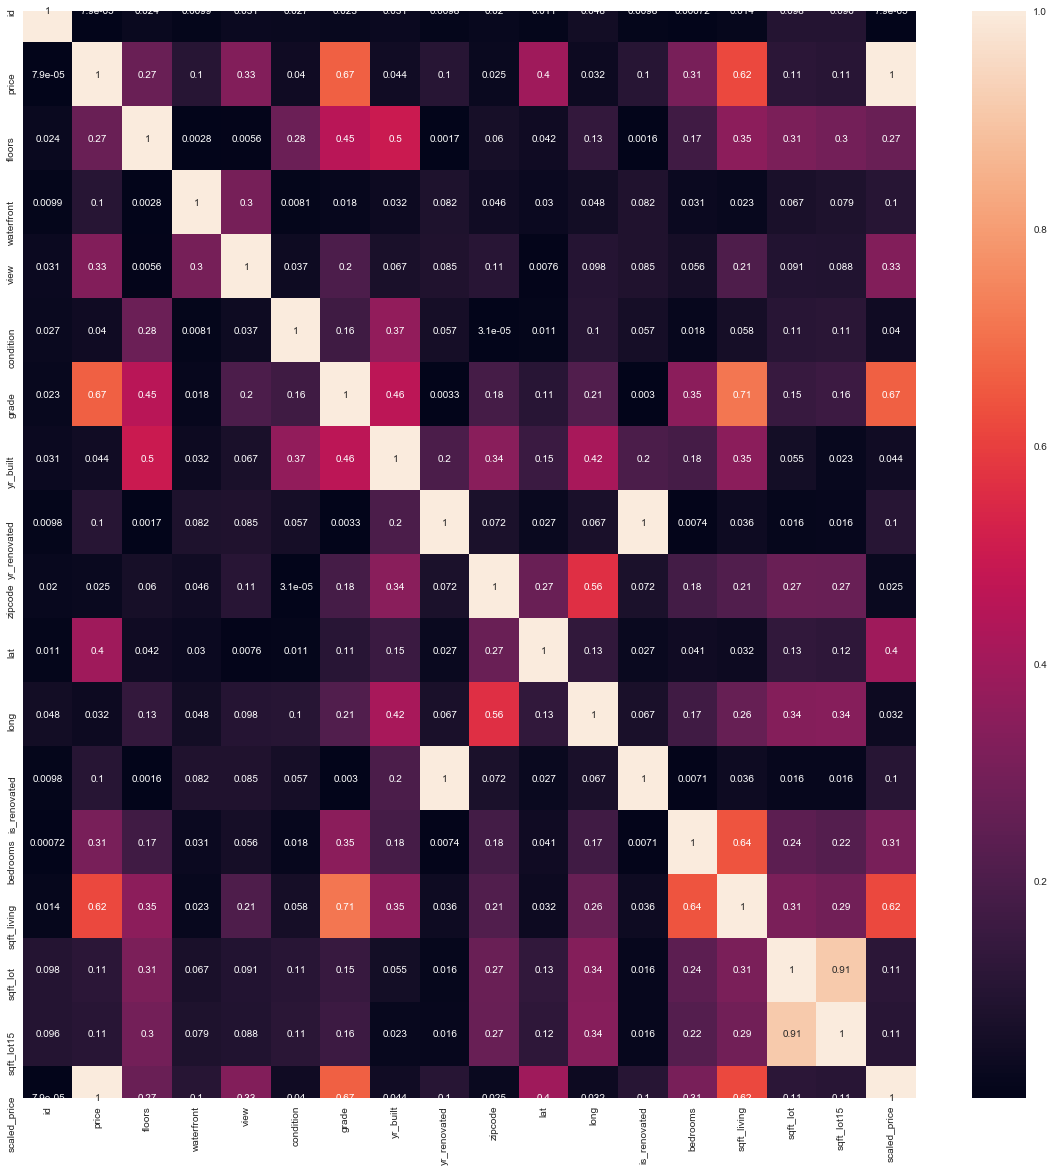

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(abs(df_scaled.drop(['price_outliers','floors_outliers','bed_outliers',
                                'sqft_living_outliers','sqft_lot_outliers','sqft_lot15_outliers'], 
                                axis=1).corr()), annot=True);

After removal, we can see that `sqft_lot15` is unacceptably highly correlated (>0.75) with `sqft_lot`. We'll drop the former, following in our earlier footsteps of removing `sqft_living15`. Additionally, the correlation between `grade` and `sqft_living` has fallen below our 0.75 threshold, but we will still use techniques to test this multicollinearity when working with our model in earnest.

In [24]:
df_scaled.drop(['sqft_lot15'], axis=1, inplace=True)

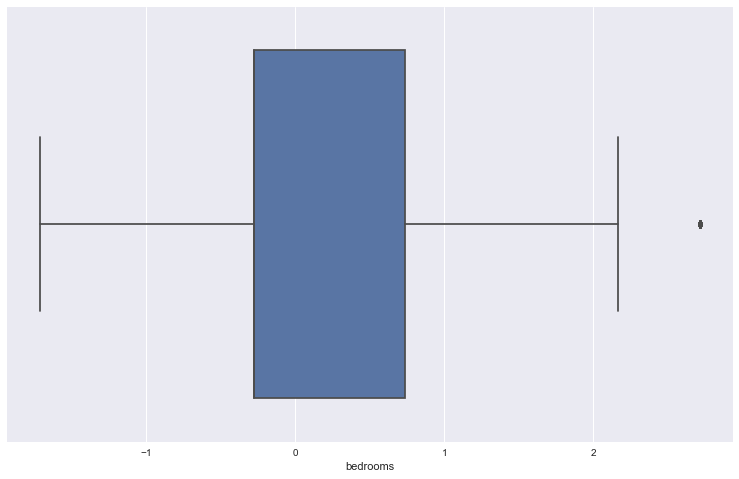

In [25]:
plt.figure(figsize=(13,8))
sns.boxplot(x='bedrooms', data=df_scaled)

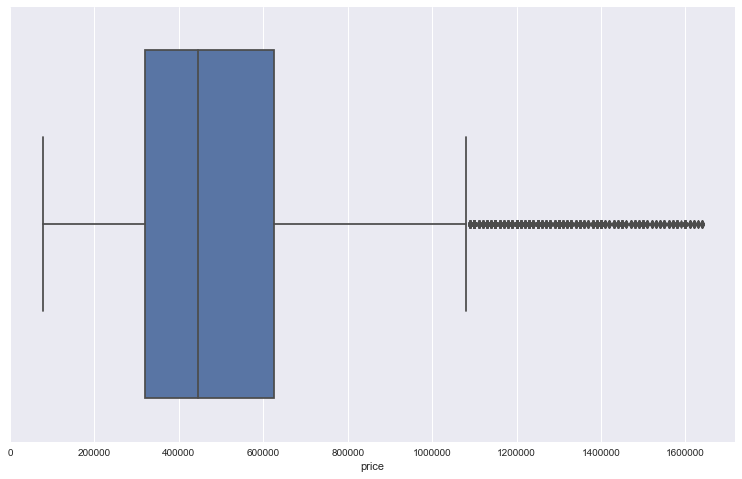

In [26]:
plt.figure(figsize=(13,8))
sns.boxplot(x='price', data=df_scaled)

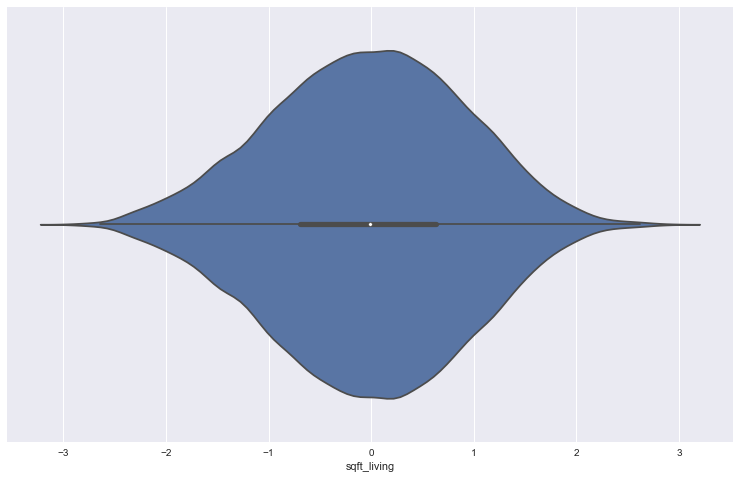

In [27]:
plt.figure(figsize=(13,8))
sns.violinplot(x='sqft_living', data=df_scaled)

Judging by our new visualizations, the distributions of `price` and `bedrooms` have greatly improved, and the skew of `sqft_living` has noticeably fallen. If we need to further fix the skew of `sqft_living`, or of any other column, we can do so at a later point. For now, we can focus on our categorical data.

### Identifying and Transforming Categorical Data

We have some categorical variables for sure. Just by eyeballing it, `waterfront`, `view`, `condition`, `grade`, `is_renovated` (as expected), and `zipcode` could all be categorical. 

In [28]:
df_scaled[['waterfront', 'view', 'condition', 'grade', 'is_renovated', 'zipcode']].describe()

,waterfront,view,condition,grade,zipcode
count,20462.000000,20462.000000,20462.000000,20462.000000,20462.000000
mean,0.003519,0.198954,3.411983,7.607712,98078.837113
std,0.059216,0.695769,0.648502,1.087720,53.628372
min,0.000000,0.000000,1.000000,4.000000,98001.000000
25%,0.000000,0.000000,3.000000,7.000000,98033.000000
50%,0.000000,0.000000,3.000000,7.000000,98070.000000
75%,0.000000,0.000000,4.000000,8.000000,98118.000000
max,1.000000,4.000000,5.000000,12.000000,98199.000000


In [29]:
df_scaled[['waterfront', 'view', 'condition', 'grade', 'is_renovated', 'zipcode']].nunique()

waterfront       2
view             5
condition        5
grade            9
is_renovated     2
zipcode         70
dtype: int64

Judging by the relatively low number of unique values in each of these columns, as well as their integer nature, it's a fairly safe bet that they can be treated as categorical. Word of note: In discussing other columns with a lower number of unique values, such as `bedrooms` and `bathrooms`, we could indeed treat these as categorical as well. However, the decision to omit these two columns from the categorical list was twofold: 1) `bedrooms` is usually colloquially paired with `bathrooms` (e.g. "This is a 3-bed, 2.5-bath house"), and 2) the latter contains float values. 

In [30]:
one_hot_columns = ['waterfront','view','condition','grade','is_renovated','zipcode']

We can one-hot-encode these columns in one step when creating the initial model. We'll do this by hand, as it is easier to remain cognizant of what is going on under the hood.

In [31]:
waterfront_dummies = pd.get_dummies(df_scaled['waterfront'], prefix='wat', drop_first=True)
view_dummies = pd.get_dummies(df_scaled['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(df_scaled['condition'], prefix='con', drop_first=True)
grade_dummies = pd.get_dummies(df_scaled['grade'], prefix='grad', drop_first=True)
is_renovated_dummies = pd.get_dummies(df_scaled['is_renovated'], prefix='ren', drop_first=True)
zipcode_dummies = pd.get_dummies(df_scaled['zipcode'], prefix='zip', drop_first=True)

Now, we'll add these columns to our scaled dataframe so we can run our preliminary model. 

In [32]:
data = pd.concat([df_scaled, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, 
                  is_renovated_dummies, zipcode_dummies], axis=1)
data.head()

,id,date,price,floors,waterfront,view,condition,grade,yr_built,yr_renovated,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,7129300520,10/13/2014,221900.0,-0.915552,0,0,3,7,1955,0.0,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,12/9/2014,538000.0,0.937431,0,0,3,7,1951,1991.0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,-0.915552,0,0,3,6,1933,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,-0.915552,0,0,5,7,1965,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,-0.915552,0,0,3,8,1987,0.0,...,0,0,0,0,0,0,0,0,0,0


Let's drop the original columns that we just encoded, as well as a few other unhelpful columns, such as `id` and `date`.

In [33]:
data.drop(one_hot_columns, axis=1, inplace=True)
data.drop(['id','date','yr_renovated','price_outliers','bed_outliers','sqft_living_outliers',
           'sqft_lot_outliers','sqft_lot15_outliers', 'scaled_price', 'floors_outliers'], axis=1, inplace=True)

In [34]:
data.columns

Index(['price', 'floors', 'yr_built', 'lat', 'long', 'bedrooms', 'sqft_living',
       'sqft_lot', 'wat_1', 'view_1', 'view_2', 'view_3', 'view_4', 'con_2',
       'con_3', 'con_4', 'con_5', 'grad_5', 'grad_6', 'grad_7', 'grad_8',
       'grad_9', 'grad_10', 'grad_11', 'grad_12', 'ren_True', 'zip_98002',
       'zip_98003', 'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007',
       'zip_98008', 'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019',
       'zip_98022', 'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028',
       'zip_98029', 'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033',
       'zip_98034', 'zip_98038', 'zip_98039', 'zip_98040', 'zip_98042',
       'zip_98045', 'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056',
       'zip_98058', 'zip_98059', 'zip_98065', 'zip_98070', 'zip_98072',
       'zip_98074', 'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102',
       'zip_98103', 'zip_98105', 'zip_98106', 'zip_98107', 'zip_98108',
       'zip_98109', 'zip_98112', 'zip_98115', 

### Preliminary Model

Let's create a preliminary model using OLS and every single column we've got. This will obviously sacrifice lots of interpretability for accuracy, but we just want a benchmark for how high our R-squared value is, just to ensure that we don't lose too much accuracy after whittling the list down to 4-7 features.

In [41]:
from statsmodels.formula.api import ols

outcome = 'price'
x_cols = data.drop('price', axis=1)
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1130.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:19:50   Log-Likelihood:            -2.6537e+05
No. Observations:               20462   AIC:                         5.309e+05
Df Residuals:                   20367   BIC:                         5.317e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.443e+07   4.37e+06     -5.590      0.000    -3.3e+07   -1.59e+07
floors       4463.5691   1046.513      4.265      0.000    2412.319    6514.819
yr_built     -157.1369     43.318     -3.628      0.000    -242.043     -72.231
lat          1.018e+05   4.36e+04      2.333      0.020    1.63e+04    1.87e+05
long        -1.645e+05   3.28e+04     -5.019      0.000   -2.29e+05      -1e+05
bedrooms    -2143.7228   1093.017     -1.961      0.050   -4286.124      -1.321
sqft_living  9.183e+04   1476.188     62.210      0.000    8.89e+04    9.47e+04
sqft_lot     2.593e+04   1358.108     19.094      0.000    2.33e+04    2.86e+04
wat_1        2.306e+05   1.44e+04     15.964      0.000    2.02e+05    2.59e+05
view_1        7.41e+04   6172.055     12.006      0.000     6.2e+04    8.62e+04
view_2       7.359e+04   3776.644     19.486      0.000    6.62e+04     8.1e+04
view_3       1.401e+05   5366.641     26.102      0.000     1.3e+05    1.51e+05
view_4       2.289e+05   8585.293     26.667      0.000    2.12e+05    2.46e+05
con_2        5.318e+04   2.31e+04      2.302      0.021    7899.807    9.85e+04
con_3         8.08e+04   2.15e+04      3.756      0.000    3.86e+04    1.23e+05
con_4        9.727e+04   2.15e+04      4.521      0.000    5.51e+04    1.39e+05
con_5        1.383e+05   2.16e+04      6.397      0.000    9.59e+04    1.81e+05
grad_5      -1.751e+04   2.89e+04     -0.605      0.545   -7.42e+04    3.92e+04
grad_6      -3.234e+04   2.81e+04     -1.151      0.250   -8.74e+04    2.27e+04
grad_7      -2.731e+04   2.81e+04     -0.972      0.331   -8.24e+04    2.78e+04
grad_8       1.847e+04   2.82e+04      0.655      0.513   -3.68e+04    7.37e+04
grad_9       1.301e+05   2.84e+04      4.588      0.000    7.45e+04    1.86e+05
grad_10      2.418e+05   2.86e+04      8.463      0.000    1.86e+05    2.98e+05
grad_11      4.006e+05   2.92e+04     13.729      0.000    3.43e+05    4.58e+05
grad_12      5.763e+05   3.45e+04     16.697      0.000    5.09e+05    6.44e+05
ren_True      4.75e+04   4348.331     10.923      0.000     3.9e+04     5.6e+04
zip_98002    2.596e+04   9511.611      2.729      0.006    7318.355    4.46e+04
zip_98003   -5475.5965   8440.541     -0.649      0.517    -2.2e+04    1.11e+04
zip_98004      6.1e+05   1.63e+04     37.468      0.000    5.78e+05    6.42e+05
zip_98005    3.212e+05    1.7e+04     18.871      0.000    2.88e+05    3.55e+05
zip_98006    2.758e+05    1.4e+04     19.654      0.000    2.48e+05    3.03e+05
zip_98007    2.547e+05   1.75e+04     14.516      0.000     2.2e+05    2.89e+05
zip_98008    2.551e+05   1.69e+04     15.131      0.000    2.22e+05    2.88e+05
zip_98010     1.02e+05   1.56e+04      6.559      0.000    7.15e+04    1.32e+05
zip_98011    1.174e+05   2.18e+04      5.378      0.000    7.46e+04     1.6e+05
zip_98014    1.147e+05   2.57e+04      4.46

Using every column, we get an adjusted R-squared of 0.838. Not bad! But this model is nigh impossible to understand with nearly one hundred columns, so let's whittle it down a bit to boost some interpretability. We'll use stepwise selection for this.

In [36]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [37]:
result = stepwise_selection(x_cols, data['price'], verbose=True)
print('resulting features:')
print(result)

C:\Users\Devin\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grad_11                        with p-value 0.0
Add  grad_7                         with p-value 0.0
Add  grad_9                         with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  grad_10                        with p-value 0.0
Add  lat                            with p-value 0.0
Add  zip_98004                      with p-value 0.0
Add  zip_98040                      with p-value 3.27906e-213
Add  grad_6                         with p-value 6.15738e-197
Add  view_4                         with p-value 2.38816e-169
Add  zip_98112                      with p-value 9.15358e-151
Add  grad_12                        with p-value 1.50811e-150
Add  zip_98155                      with p-value 3.78199e-109
Add  zip_98133                      with p-value 1.11584e-103
Add  view_3                         with p-value 2.9962e-102
Add  zip_98028                      with p-value 1.64765e-100
Add  zip_98039     

C:\Users\Devin\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zip_98008                      with p-value 2.58322e-18
Add  zip_98075                      with p-value 3.95368e-15
Add  zip_98007                      with p-value 3.67848e-15
Add  zip_98118                      with p-value 1.73017e-12
Add  zip_98052                      with p-value 1.77526e-10
Add  zip_98053                      with p-value 1.63865e-09
Add  zip_98074                      with p-value 8.97672e-08
Drop zip_98177                      with p-value 0.895914
Add  zip_98038                      with p-value 7.4095e-07
Drop zip_98125                      with p-value 0.067957
Add  zip_98059                      with p-value 9.80238e-07
Add  zip_98065                      with p-value 6.58492e-07
Add  zip_98010                      with p-value 1.67852e-06
Add  grad_8                         with p-value 6.56981e-06
Drop grad_7                         with p-value 0.154611
Add  zip_98166                      with p-value 9.34036e-05
Drop grad_6                       

In [47]:
len(result)

75

75 columns is barely fewer than what we started with, let's see if it made a big difference in our adjusted R-squared.

In [48]:
outcome = 'price'
cols = result
predictors = '+'.join(cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1408.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:31:07   Log-Likelihood:            -2.6543e+05
No. Observations:               20462   AIC:                         5.310e+05
Df Residuals:                   20386   BIC:                         5.316e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.174e+07   2.09e+06    -19.975      0.000   -4.58e+07   -3.76e+07
grad_11      4.279e+05   7343.154     58.269      0.000    4.13e+05    4.42e+05
grad_9       1.576e+05   3091.161     50.976      0.000    1.52e+05    1.64e+05
sqft_living   9.05e+04   1159.509     78.047      0.000    8.82e+04    9.28e+04
grad_10      2.697e+05   4459.998     60.477      0.000    2.61e+05    2.78e+05
lat          4.908e+05   1.02e+04     47.927      0.000    4.71e+05    5.11e+05
zip_98004    4.879e+05   7332.374     66.546      0.000    4.74e+05    5.02e+05
zip_98040    3.674e+05   7128.731     51.535      0.000    3.53e+05    3.81e+05
view_4       2.304e+05   8580.964     26.850      0.000    2.14e+05    2.47e+05
zip_98112    3.784e+05   7545.617     50.143      0.000    3.64e+05    3.93e+05
grad_12      6.065e+05   1.98e+04     30.580      0.000    5.68e+05    6.45e+05
zip_98155   -8.002e+04   5828.270    -13.729      0.000   -9.14e+04   -6.86e+04
zip_98133   -5.541e+04   5609.128     -9.878      0.000   -6.64e+04   -4.44e+04
view_3       1.415e+05   5371.165     26.348      0.000    1.31e+05    1.52e+05
zip_98028   -7.537e+04   6983.399    -10.792      0.000   -8.91e+04   -6.17e+04
zip_98039    6.757e+05   2.47e+04     27.337      0.000    6.27e+05    7.24e+05
view_2       7.449e+04   3778.715     19.713      0.000    6.71e+04    8.19e+04
zip_98011   -5.925e+04   8290.483     -7.147      0.000   -7.55e+04    -4.3e+04
zip_98019   -6.102e+04   1.05e+04     -5.820      0.000   -8.16e+04   -4.05e+04
zip_98072   -2.826e+04   7764.217     -3.639      0.000   -4.35e+04    -1.3e+04
zip_98077   -3.516e+04   9510.499     -3.697      0.000   -5.38e+04   -1.65e+04
con_5        9.208e+04   8557.278     10.761      0.000    7.53e+04    1.09e+05
zip_98119    2.894e+05   8475.998     34.139      0.000    2.73e+05    3.06e+05
zip_98105    2.819e+05   7790.494     36.186      0.000    2.67e+05    2.97e+05
zip_98109    3.202e+05   1.08e+04     29.568      0.000    2.99e+05    3.41e+05
zip_98014   -3.393e+04   1.42e+04     -2.396      0.017   -6.17e+04   -6167.759
zip_98006    1.747e+05   5644.717     30.941      0.000    1.64e+05    1.86e+05
zip_98178   -4.357e+04   6730.421     -6.473      0.000   -5.68e+04   -3.04e+04
wat_1        2.343e+05   1.44e+04     16.242      0.000    2.06e+05    2.63e+05
zip_98022    8.828e+04   9253.786      9.540      0.000    7.01e+04    1.06e+05
zip_98168   -5.341e+04   6739.584     -7.924      0.000   -6.66e+04   -4.02e+04
zip_98102    2.976e+05    1.1e+04     26.971      0.000    2.76e+05    3.19e+05
zip_98199    2.028e+05   6766.687     29.971      0.000     1.9e+05    2.16e+05
zip_98116    1.616e+05   6512.906     24.816      0.000    1.49e+05    1.74e+05
view_1       7.541e+04   6175.128     12.212      0.000    6.33e+04    8.75e+04
zip_98005    2.004e+05   8710.811     23.00

As we suspected, zero change in our adjusted R-squared. There are clearly too many features to interpret the model in any meaningful way, so let's run Regressive Feature Elimination instead.

### Feature Selection with RFE

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=1)
selector = selector.fit(x_cols.drop(['lat','long'], axis=1), data['price'])
selector.ranking_

array([89, 92, 91, 42, 80, 22, 58, 57, 17,  7, 68, 67, 66, 63, 79, 70, 69,
       81, 12,  5,  3,  1, 64, 84, 88,  4, 15, 19, 29, 26, 61, 47, 60, 59,
       90, 77, 45, 35, 48, 33, 86, 82, 87, 16, 39, 74,  2,  6, 85, 50, 27,
       28, 72, 56, 75, 52, 49, 62, 37, 36, 31, 38, 78, 13, 20, 11, 53, 23,
       54,  9,  8, 18, 25, 24, 43, 10, 21, 40, 41, 44, 34, 32, 55, 65, 46,
       51, 71, 30, 73, 76, 83, 14])

In [50]:
x_cols.drop(['lat','long'], axis=1).columns

Index(['floors', 'yr_built', 'bedrooms', 'sqft_living', 'sqft_lot', 'wat_1',
       'view_1', 'view_2', 'view_3', 'view_4', 'con_2', 'con_3', 'con_4',
       'con_5', 'grad_5', 'grad_6', 'grad_7', 'grad_8', 'grad_9', 'grad_10',
       'grad_11', 'grad_12', 'ren_True', 'zip_98002', 'zip_98003', 'zip_98004',
       'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008', 'zip_98010',
       'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023',
       'zip_98024', 'zip_98027', 'zip_98028', 'zip_98029', 'zip_98030',
       'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038',
       'zip_98039', 'zip_98040', 'zip_98042', 'zip_98045', 'zip_98052',
       'zip_98053', 'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059',
       'zip_98065', 'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075',
       'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105',
       'zip_98106', 'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112',
       'zip_98115', 'zip_98116', 'zip_98117'

Note: We've dropped `lat` and `long` due to those being geographical and, therefore, not necessarily continuous *or* categorical.

In [51]:
import operator

rankings = list(zip(selector.ranking_,x_cols.drop(['lat','long'],axis=1).columns))
rankings.sort(key=operator.itemgetter(0))
rankings

[(1, 'grad_12'),
 (2, 'zip_98039'),
 (3, 'grad_11'),
 (4, 'zip_98004'),
 (5, 'grad_10'),
 (6, 'zip_98040'),
 (7, 'view_4'),
 (8, 'zip_98112'),
 (9, 'zip_98109'),
 (10, 'zip_98119'),
 (11, 'zip_98105'),
 (12, 'grad_9'),
 (13, 'zip_98102'),
 (14, 'zip_98199'),
 (15, 'zip_98005'),
 (16, 'zip_98033'),
 (17, 'view_3'),
 (18, 'zip_98115'),
 (19, 'zip_98006'),
 (20, 'zip_98103'),
 (21, 'zip_98122'),
 (22, 'wat_1'),
 (23, 'zip_98107'),
 (24, 'zip_98117'),
 (25, 'zip_98116'),
 (26, 'zip_98008'),
 (27, 'zip_98052'),
 (28, 'zip_98053'),
 (29, 'zip_98007'),
 (30, 'zip_98177'),
 (31, 'zip_98075'),
 (32, 'zip_98144'),
 (33, 'zip_98029'),
 (34, 'zip_98136'),
 (35, 'zip_98027'),
 (36, 'zip_98074'),
 (37, 'zip_98072'),
 (38, 'zip_98077'),
 (39, 'zip_98034'),
 (40, 'zip_98125'),
 (41, 'zip_98126'),
 (42, 'sqft_living'),
 (43, 'zip_98118'),
 (44, 'zip_98133'),
 (45, 'zip_98024'),
 (46, 'zip_98155'),
 (47, 'zip_98011'),
 (48, 'zip_98028'),
 (49, 'zip_98065'),
 (50, 'zip_98045'),
 (51, 'zip_98166'),
 (52, 

At this point, we have a decision to make. The more ZIP codes we choose to include in our model (i.e. the more of our ranked list we choose to tap), the more unique non-ZIP columns we'll have to use. We need to pick the amount of the list that will give us a robust model while still keeping the amount of information digestible. 

Fortuitously, we can use an elbow plot to find the point at which further addition of columns gives diminishing returns.

In [43]:
r_squared = []
for x in range(1, len(x_cols.drop(['lat','long'], axis=1).columns)):
    selector = RFE(linreg, n_features_to_select=x)
    selector.fit(x_cols.drop(['lat','long'], axis=1), data['price'])
    linreg.fit(x_cols[x_cols.drop(['lat','long'], axis=1).columns[selector.support_]], data['price'])
    r_sq = linreg.score(x_cols[x_cols.drop(['lat','long'], axis=1).columns[selector.support_]], data['price'])
    r_squared.append(r_sq)

In [44]:
r_squared

[0.016540694159059566,
 0.02321281213053561,
 0.0986046957810548,
 0.14282229378828593,
 0.274915016509809,
 0.3035872953091885,
 0.32789593697514907,
 0.35311640726108784,
 0.3606693246326652,
 0.37256427055219976,
 0.38584953216309126,
 0.5070222869939089,
 0.5109168875503166,
 0.5221840767381837,
 0.5278915190680215,
 0.5407794970692507,
 0.5527385838602075,
 0.5665008435714265,
 0.5759802689398975,
 0.5885320850132498,
 0.5947044198929401,
 0.5958267542193751,
 0.6009769444681101,
 0.6121218005475036,
 0.6183613602773269,
 0.6236625505415794,
 0.6344922344789712,
 0.6415720873603918,
 0.6443851914687286,
 0.6488264845940839,
 0.6546760285481064,
 0.6599599910357878,
 0.6645177522674428,
 0.6682548104315419,
 0.6735314023583839,
 0.6792321755401233,
 0.6823036674105285,
 0.6842983377137433,
 0.6896738805321876,
 0.6934239244197733,
 0.695167164544396,
 0.7948031801576981,
 0.7981552752975956,
 0.8016219550909861,
 0.8019454478524756,
 0.8048097589297891,
 0.8059304657875204,
 0.8075

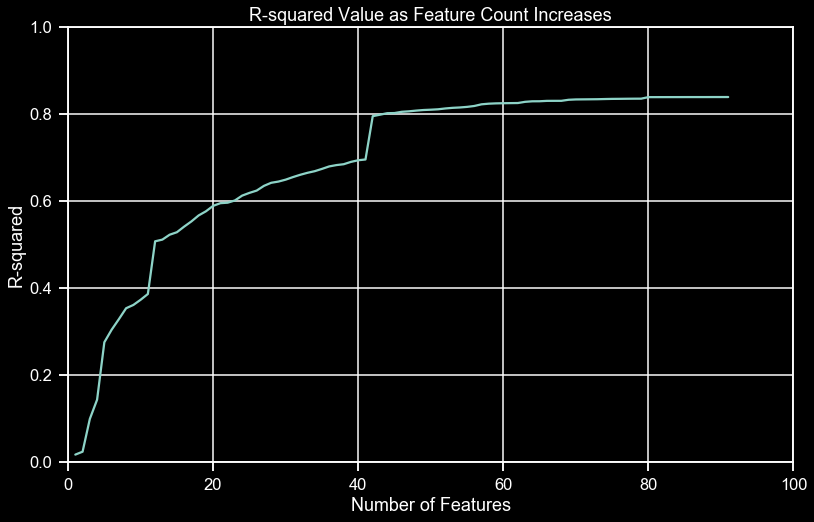

In [149]:
plt.figure(figsize=(13,8))
plt.xlabel('Number of Features')
plt.xlim(0,100)
plt.ylabel('R-squared')
plt.ylim(0,1)
plt.title('R-squared Value as Feature Count Increases')
plt.plot(range(1, len(x_cols.drop(['lat','long'], axis=1).columns)), r_squared)

It looks like we can stop adding columns once we've crested that last big jump right after 40. Taking another look at our `r_squared` list, we can see that this happens after exactly 42 columns.

In [65]:
columns_final = [rank[1] for rank in rankings[:42]]
columns_final

['grad_12',
 'zip_98039',
 'grad_11',
 'zip_98004',
 'grad_10',
 'zip_98040',
 'view_4',
 'zip_98112',
 'zip_98109',
 'zip_98119',
 'zip_98105',
 'grad_9',
 'zip_98102',
 'zip_98199',
 'zip_98005',
 'zip_98033',
 'view_3',
 'zip_98115',
 'zip_98006',
 'zip_98103',
 'zip_98122',
 'wat_1',
 'zip_98107',
 'zip_98117',
 'zip_98116',
 'zip_98008',
 'zip_98052',
 'zip_98053',
 'zip_98007',
 'zip_98177',
 'zip_98075',
 'zip_98144',
 'zip_98029',
 'zip_98136',
 'zip_98027',
 'zip_98074',
 'zip_98072',
 'zip_98077',
 'zip_98034',
 'zip_98125',
 'zip_98126',
 'sqft_living']

This list of columns is comprised of five unique features of King County home sales: the square footage of the living space, a waterfront view, a high level of interest in the property (>2 views), a high construction grade from King County (>8), and a collection of high-value ZIP codes. 

Let's see how this collection of features does in our new model.

In [66]:
outcome = 'price'
predictors = '+'.join(columns_final)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1883.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:36:26   Log-Likelihood:            -2.6787e+05
No. Observations:               20462   AIC:                         5.358e+05
Df Residuals:                   20419   BIC:                         5.362e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.511e+05   1245.370    281.937      0.000    3.49e+05    3.54e+05
grad_12      5.703e+05   2.21e+04     25.797      0.000    5.27e+05    6.14e+05
zip_98039    7.939e+05   2.77e+04     28.667      0.000     7.4e+05    8.48e+05
grad_11      3.954e+05   7795.779     50.726      0.000     3.8e+05    4.11e+05
zip_98004    5.734e+05   7870.496     72.858      0.000    5.58e+05    5.89e+05
grad_10       2.32e+05   4436.397     52.300      0.000    2.23e+05    2.41e+05
zip_98040     4.48e+05   7758.577     57.741      0.000    4.33e+05    4.63e+05
view_4       2.423e+05   9600.465     25.238      0.000    2.23e+05    2.61e+05
zip_98112    4.691e+05   7952.769     58.988      0.000    4.54e+05    4.85e+05
zip_98109    4.239e+05   1.17e+04     36.102      0.000    4.01e+05    4.47e+05
zip_98119    3.968e+05   8936.151     44.402      0.000    3.79e+05    4.14e+05
zip_98105    3.907e+05   8246.504     47.377      0.000    3.75e+05    4.07e+05
grad_9       1.236e+05   2872.803     43.034      0.000    1.18e+05    1.29e+05
zip_98102    3.809e+05    1.2e+04     31.756      0.000    3.57e+05    4.04e+05
zip_98199    3.244e+05   6887.684     47.097      0.000    3.11e+05    3.38e+05
zip_98005    2.866e+05   9332.382     30.707      0.000    2.68e+05    3.05e+05
zip_98033    2.959e+05   5940.555     49.806      0.000    2.84e+05    3.08e+05
view_3       1.435e+05   5947.722     24.122      0.000    1.32e+05    1.55e+05
zip_98115     2.75e+05   5040.119     54.566      0.000    2.65e+05    2.85e+05
zip_98006    2.304e+05   5674.959     40.606      0.000    2.19e+05    2.42e+05
zip_98103    2.738e+05   5006.696     54.696      0.000    2.64e+05    2.84e+05
zip_98122    2.726e+05   7168.019     38.029      0.000    2.59e+05    2.87e+05
wat_1        2.569e+05   1.59e+04     16.137      0.000    2.26e+05    2.88e+05
zip_98107    2.694e+05   7399.314     36.408      0.000    2.55e+05    2.84e+05
zip_98117    2.574e+05   5194.106     49.561      0.000    2.47e+05    2.68e+05
zip_98116    2.433e+05   6663.801     36.515      0.000     2.3e+05    2.56e+05
zip_98008    1.994e+05   7167.272     27.822      0.000    1.85e+05    2.13e+05
zip_98052    1.908e+05   5084.911     37.527      0.000    1.81e+05    2.01e+05
zip_98053    1.827e+05   6366.414     28.703      0.000     1.7e+05    1.95e+05
zip_98007    1.983e+05   9966.075     19.894      0.000    1.79e+05    2.18e+05
zip_98177    1.828e+05   7639.078     23.934      0.000    1.68e+05    1.98e+05
zip_98075    1.623e+05   6580.993     24.656      0.000    1.49e+05    1.75e+05
zip_98144    1.979e+05   6631.533     29.842      0.000    1.85e+05    2.11e+05
zip_98029    1.603e+05   6735.748     23.799      0.000    1.47e+05    1.74e+05
zip_98136    2.009e+05   7469.641     26.900      0.000    1.86e+05    2.16e+05
zip_98027    1.351e+05   6247.691     21.63

### Last Check for Multicollinearity

Using 42 columns gives us an adjusted R-squared of 0.794. At this point, we need to do one last check for multicollinearity, between `grade` and `sqft_living`. One at a time, we'll be temporarily removing both from our model. If our R-squared goes down measurably after this, we know that there is no real multicollinearity between the two columns. However, if R-squared stays relatively close to 0.794, we can safely remove one of the columns.

In [67]:
indices = [0,2,4,11]
final_minus_grade = [i for j, i in enumerate(columns_final) if j not in indices]

outcome = 'price'
predictors = '+'.join(final_minus_grade)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1523.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:36:31   Log-Likelihood:            -2.7032e+05
No. Observations:               20462   AIC:                         5.407e+05
Df Residuals:                   20423   BIC:                         5.410e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.726e+05   1347.794    276.416      0.000     3.7e+05    3.75e+05
zip_98039    7.937e+05   3.12e+04     25.426      0.000    7.33e+05    8.55e+05
zip_98004    5.982e+05   8860.357     67.514      0.000    5.81e+05    6.16e+05
zip_98040    5.012e+05   8702.076     57.600      0.000    4.84e+05    5.18e+05
view_4       2.896e+05   1.08e+04     26.816      0.000    2.68e+05    3.11e+05
zip_98112    4.984e+05   8946.962     55.707      0.000    4.81e+05    5.16e+05
zip_98109    4.433e+05   1.32e+04     33.501      0.000    4.17e+05    4.69e+05
zip_98119    4.137e+05   1.01e+04     41.100      0.000    3.94e+05    4.33e+05
zip_98105    4.021e+05   9292.083     43.271      0.000    3.84e+05     4.2e+05
zip_98102    4.201e+05   1.35e+04     31.118      0.000    3.94e+05    4.47e+05
zip_98199    3.458e+05   7754.144     44.597      0.000    3.31e+05    3.61e+05
zip_98005    3.115e+05   1.05e+04     29.637      0.000    2.91e+05    3.32e+05
zip_98033    3.224e+05   6681.197     48.253      0.000    3.09e+05    3.35e+05
view_3       1.774e+05   6684.832     26.533      0.000    1.64e+05     1.9e+05
zip_98115    2.741e+05   5681.759     48.245      0.000    2.63e+05    2.85e+05
zip_98006    2.836e+05   6333.055     44.780      0.000    2.71e+05    2.96e+05
zip_98103    2.773e+05   5643.955     49.124      0.000    2.66e+05    2.88e+05
zip_98122    2.867e+05   8075.788     35.503      0.000    2.71e+05    3.03e+05
wat_1        2.352e+05   1.79e+04     13.111      0.000       2e+05     2.7e+05
zip_98107    2.735e+05   8341.237     32.784      0.000    2.57e+05     2.9e+05
zip_98117    2.635e+05   5854.484     45.009      0.000    2.52e+05    2.75e+05
zip_98116    2.509e+05   7510.944     33.402      0.000    2.36e+05    2.66e+05
zip_98008    1.923e+05   8079.008     23.808      0.000    1.77e+05    2.08e+05
zip_98052    2.107e+05   5720.529     36.827      0.000    1.99e+05    2.22e+05
zip_98053     2.02e+05   7168.505     28.184      0.000    1.88e+05    2.16e+05
zip_98007    2.164e+05   1.12e+04     19.270      0.000    1.94e+05    2.38e+05
zip_98177    1.839e+05   8610.541     21.362      0.000    1.67e+05    2.01e+05
zip_98075    2.359e+05   7293.847     32.337      0.000    2.22e+05     2.5e+05
zip_98144    1.991e+05   7475.489     26.640      0.000    1.84e+05    2.14e+05
zip_98029    1.832e+05   7575.079     24.188      0.000    1.68e+05    1.98e+05
zip_98136    2.071e+05   8419.663     24.602      0.000    1.91e+05    2.24e+05
zip_98027    1.592e+05   7032.388     22.642      0.000    1.45e+05    1.73e+05
zip_98074    1.917e+05   6569.168     29.181      0.000    1.79e+05    2.05e+05
zip_98072    1.346e+05   8331.304     16.155      0.000    1.18e+05    1.51e+05
zip_98077    1.871e+05   1.01e+04     18.509      0.000    1.67e+05    2.07e+05
zip_98034    1.277e+05   5872.662     21.74

There is a small change in our adjusted R-squared post removal. However, this change is not small enough to justify removal of the `grade` feature, and touching on renovation when discussing home sales is good business practice. Just in case, let's see what happens if we drop `sqft_living`.

In [59]:
outcome = 'price'
predictors = '+'.join(columns_final[:41])
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     1136.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:05:58   Log-Likelihood:            -2.7191e+05
No. Observations:               20462   AIC:                         5.439e+05
Df Residuals:                   20420   BIC:                         5.442e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.207e+05   1471.359    217.932      0.000    3.18e+05    3.24e+05
grad_12     7.809e+05   2.68e+04     29.117      0.000    7.28e+05    8.33e+05
zip_98039   8.314e+05   3.38e+04     24.634      0.000    7.65e+05    8.98e+05
grad_11     5.893e+05   9200.392     64.055      0.000    5.71e+05    6.07e+05
zip_98004   5.967e+05   9588.368     62.237      0.000    5.78e+05    6.16e+05
grad_10     3.824e+05   5084.203     75.212      0.000    3.72e+05    3.92e+05
zip_98040    4.87e+05   9444.165     51.562      0.000    4.68e+05    5.05e+05
view_4      2.926e+05   1.17e+04     25.041      0.000     2.7e+05    3.16e+05
zip_98112   4.735e+05   9692.742     48.850      0.000    4.54e+05    4.92e+05
zip_98109   4.146e+05   1.43e+04     28.974      0.000    3.87e+05    4.43e+05
zip_98119   3.802e+05   1.09e+04     34.918      0.000    3.59e+05    4.02e+05
zip_98105   3.865e+05   1.01e+04     38.451      0.000    3.67e+05    4.06e+05
grad_9      2.356e+05   3222.180     73.107      0.000    2.29e+05    2.42e+05
zip_98102   3.464e+05   1.46e+04     23.703      0.000    3.18e+05    3.75e+05
zip_98199     3.2e+05   8394.588     38.125      0.000    3.04e+05    3.36e+05
zip_98005   3.316e+05   1.14e+04     29.190      0.000    3.09e+05    3.54e+05
zip_98033   3.095e+05   7238.476     42.755      0.000    2.95e+05    3.24e+05
view_3       1.95e+05   7221.639     27.001      0.000    1.81e+05    2.09e+05
zip_98115   2.667e+05   6142.092     43.425      0.000    2.55e+05    2.79e+05
zip_98006   2.653e+05   6903.489     38.433      0.000    2.52e+05    2.79e+05
zip_98103   2.462e+05   6092.789     40.404      0.000    2.34e+05    2.58e+05
zip_98122   2.482e+05   8731.310     28.422      0.000    2.31e+05    2.65e+05
wat_1       2.311e+05   1.94e+04     11.914      0.000    1.93e+05    2.69e+05
zip_98107   2.306e+05   9005.817     25.604      0.000    2.13e+05    2.48e+05
zip_98117   2.314e+05   6322.607     36.602      0.000    2.19e+05    2.44e+05
zip_98116   2.245e+05   8118.614     27.652      0.000    2.09e+05     2.4e+05
zip_98008   2.188e+05   8732.300     25.055      0.000    2.02e+05    2.36e+05
zip_98052    2.21e+05   6186.516     35.721      0.000    2.09e+05    2.33e+05
zip_98053   2.195e+05   7746.377     28.334      0.000    2.04e+05    2.35e+05
zip_98007    2.15e+05   1.21e+04     17.701      0.000    1.91e+05    2.39e+05
zip_98177   2.029e+05   9307.333     21.796      0.000    1.85e+05    2.21e+05
zip_98075   2.069e+05   8002.355     25.851      0.000    1.91e+05    2.23e+05
zip_98144    1.84e+05   8080.767     22.770      0.000    1.68e+05       2e+05
zip_98029   1.763e+05   8207.247     21.478      0.000     1.6e+05    1.92e+05
zip_98136   1.695e+05   9095.922     18.636      0.000    1.52e+05    1.87e+05
zip_98027   1.685e+05   7603.775     22.160      0.000    1.54e+05    1.83e+05
zi

Our adjusted R-squared went down by 0.1, which is large enough by itself to justify keeping `sqft_living` in the model. There is the additional factor that the square footage of the home is, like the housing grade, worth talking about when discussing real estate renovation. 

### Model Validation

Now that we've got our model, we can use K-fold validation.

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[columns_final], data['price'], test_size=0.2)
print(len(X_train), len(X_test), len(y_train), len(y_test))

16369 4093 16369 4093


In [61]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [62]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [63]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)
print('Train RMSE:', np.sqrt(mse_train))
print('Test RMSE:', np.sqrt(mse_test))

Train Mean Squared Error: 13658934738.216331
Test Mean Squared Error: 14180497917.57638
Train RMSE: 116871.44535007827
Test RMSE: 119081.89584305575


In [66]:
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, data[columns_final], data['price'], cv=5,  scoring='r2'))
cv_10_results = np.mean(cross_val_score(linreg, data[columns_final], data['price'], cv=10, scoring='r2'))
cv_20_results = np.mean(cross_val_score(linreg, data[columns_final], data['price'], cv=20, scoring='r2'))

In [67]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

0.7920336120902414
0.7916646614408366
0.7919274037102296


Looks like our R-squared is consistent across all validation tests. 

# Conclusion

As we have seen from our model, 79% of the price of a house can be predicted from just five features: ZIP code, King County housing grade, size of living space, the home's view count before selling, and whether or not the home is by the water. Specifically, the model recommends the following:

* Buy homes in certain ZIP codes over others.
* Increase the King County housing grade to at least 9.
* Increase the size of the living space.
* Buy houses that are near or on the waterfront.
* Increase interest in the property. Specifically, 3 views or more will increase selling price.

### Extra: Creating Visualizations of Features

This is an extra section wherein the raw code for the graphs in the non-technical presentation is housed.

Text(0.5, 1.0, 'Zipcode')

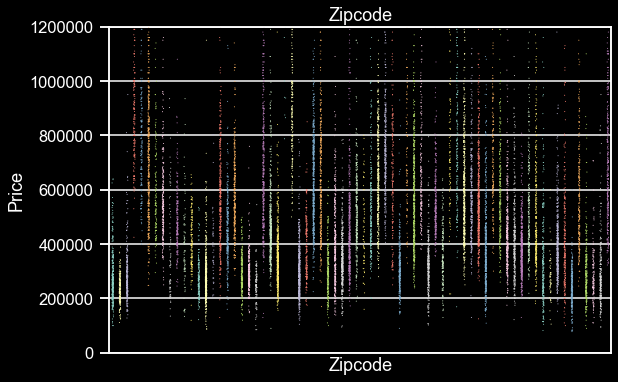

In [69]:
plt.style.use('dark_background')

sns.set_context('talk')
f, ax = plt.subplots(figsize=(9,6))
ax = sns.stripplot(x=df_scaled['zipcode'], y=df_scaled['price'], size=1, palette='Set3')
ax.set_xlabel('Zipcode', fontname='Arial')
ax.set_xticks([])
ax.set_ylim(0,1200000)
ax.set_ylabel('Price', fontname='Arial')
ax.set_title('Zipcode', fontname='Arial')

Text(0.5, 1.0, 'Living Space')

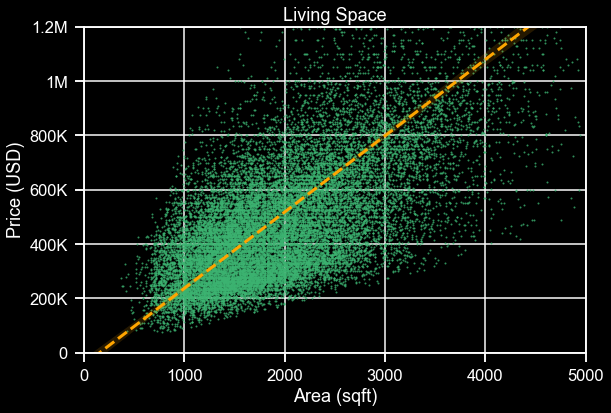

In [132]:
f, ax = plt.subplots(figsize=(9,6))
ax = sns.regplot(x='sqft_living', y='price', data=df, color='mediumseagreen', scatter_kws={'s':4}, 
            line_kws={'linewidth':3,'linestyle':'dashed','color':'orange'})
ax.set_xlim(0,5000)
ax.set_ylim(0,1200000)
ax.set_xlabel('Area (sqft)', fontname='Arial')
ax.set_ylabel('Price (USD)', fontname='Arial')
ax.set_yticklabels(['0','200K','400K','600K','800K','1M','1.2M'])
ax.set_title('Living Space', fontname='Arial')

Text(0.5, 1.0, 'Housing Grade')

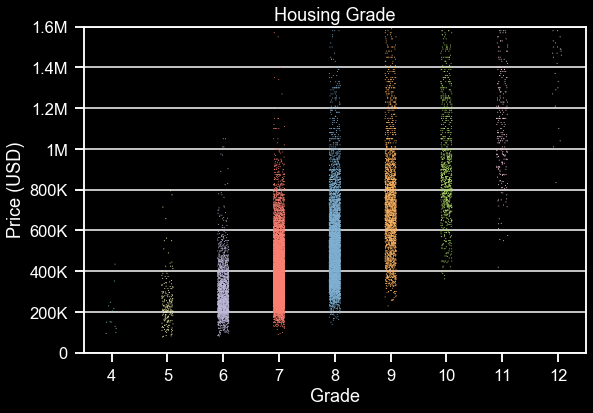

In [133]:
f, ax = plt.subplots(figsize=(9,6))
ax = sns.stripplot(x=df_scaled['grade'], y=df_scaled['price'], size=1, palette='Set3')
ax.set_ylim(0,1600000)
ax.set_xlabel('Grade', fontname='Arial')
ax.set_ylabel('Price (USD)', fontname='Arial')
ax.set_yticklabels(['0','200K','400K','600K','800K','1M','1.2M','1.4M','1.6M'])
ax.set_title('Housing Grade', fontname='Arial')

Text(0.5, 1.0, 'Waterfront View')

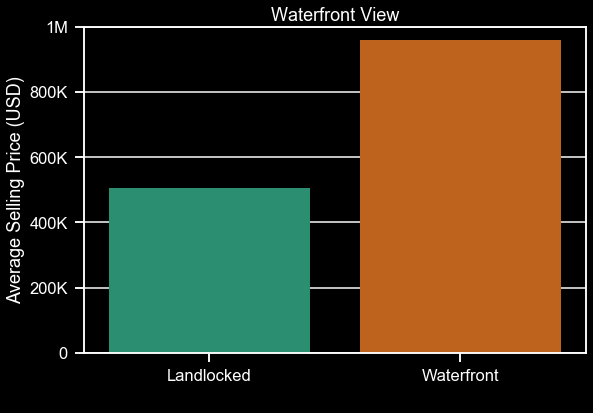

In [135]:
f, ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x=df_scaled['waterfront'], y=df_scaled['price'], palette='Dark2', errwidth=0)
ax.set_ylim(0,1000000)
ax.set_xlabel(' ', fontname='Arial')
ax.set_xticklabels(['Landlocked','Waterfront'])
ax.set_ylabel('Average Selling Price (USD)', fontname='Arial')
ax.set_yticklabels(['0','200K','400K','600K','800K','1M'])
ax.set_title('Waterfront View', fontname='Arial')

In [97]:
df_scaled.groupby('waterfront')['price'].mean()

waterfront
0    504717.119225
1    960200.694444
Name: price, dtype: float64

Text(0.5, 1.0, 'Number of Viewings')

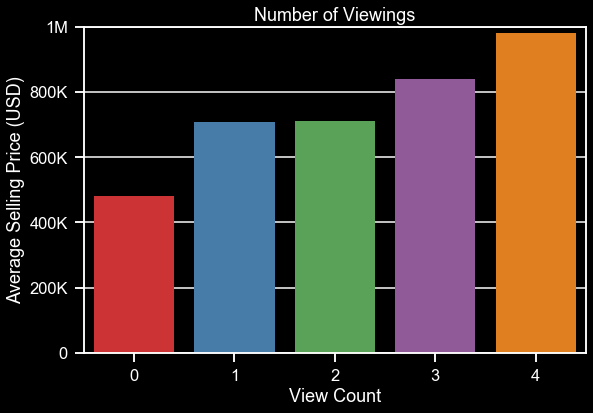

In [146]:
f, ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x=df_scaled['view'], y=df_scaled['price'], palette='Set1', errwidth=0)
ax.set_ylim(0,1000000)
ax.set_xlabel('View Count', fontname='Arial')
ax.set_ylabel('Average Selling Price (USD)', fontname='Arial')
ax.set_yticklabels(['0','200K','400K','600K','800K','1M'])
ax.set_title('Number of Viewings', fontname='Arial')

In [141]:
df_scaled.groupby('view')['price'].mean()

view
0    481222.315995
1    706498.930233
2    709593.089953
3    839074.502415
4    981717.573529
Name: price, dtype: float64